In [2]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## Load a pretrained Resnet Model

In [6]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """
        This class extracts the feature maps from a pretrained Resnet model.
        """
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """
            This hook saves the extracted feature map on self.featured.
            """
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2] # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1) # Merge the resized feature maps
        patch = patch.reshape(patch.shape[1], -1).T # Craete a column tensor

        return patch

In [7]:
image = Image.open('/content/transistor/test/damaged_case/000.png')
image = transform(image).unsqueeze(0).cuda()

backbone = resnet_feature_extractor().cuda()
feature = backbone(image)

# print(backbone.features[0].shape)
# print(backbone.features[1].shape)

print(feature.shape)

# plt.imshow(image[0].permute(1,2,0))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


torch.Size([784, 1536])


## Create memory bank from 'normal' data

In [8]:
memory_bank =[]

folder_path = Path('/content/transistor/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = backbone(data)
        memory_bank.append(features.cpu().detach())

memory_bank = torch.cat(memory_bank,dim=0).cuda()

0it [00:00, ?it/s]

## Only select 10% of total patches to avoid long inference time and computation

In [9]:
selected_indices = np.random.choice(len(memory_bank), size=len(memory_bank)//10, replace=False)
memory_bank = memory_bank[selected_indices]

## For OK images [K nearsest neighbours]

In [10]:
y_score=[]
folder_path = Path('/content/transistor/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = backbone(data)
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1)
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28)

    y_score.append(s_star.cpu().numpy())

0it [00:00, ?it/s]

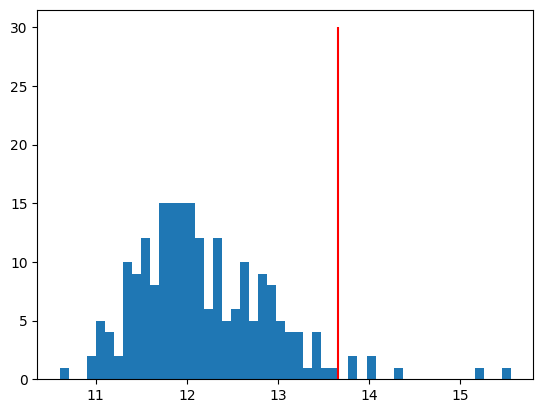

In [11]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

## For NOK Images

In [12]:
y_score = []
y_true=[]

for classes in ['bent_lead', 'cut_lead', 'damaged_case', 'good', 'misplaced']:
    folder_path = Path('/content/transistor/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)

        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1)
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28)

        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

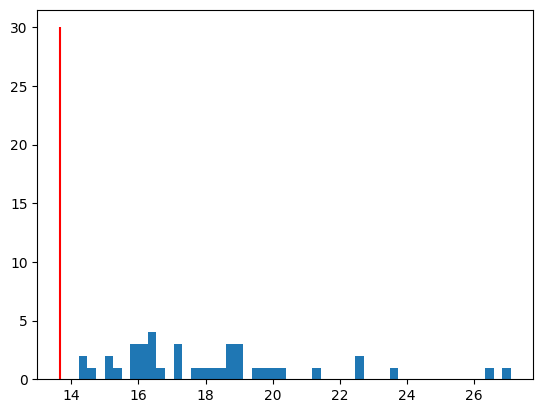

In [13]:
# Plotting the y_score values which do not belong to 'good' class
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

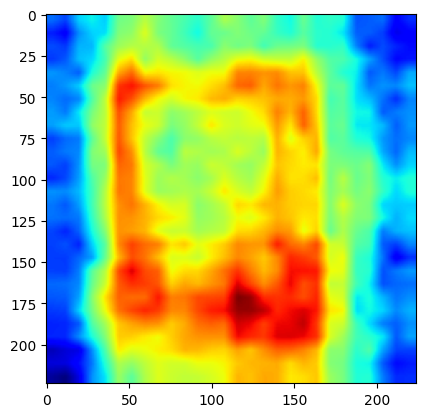

In [14]:
test_image = transform(Image.open('/content/transistor/test/misplaced/000.png')).cuda().unsqueeze(0)
features = backbone(test_image)

distances = torch.cdist(features, memory_bank, p=2.0)
dist_score, dist_score_idxs = torch.min(distances, dim=1)
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

# Upscale by bi-linaer interpolation to match the original input resolution
segm_map = torch.nn.functional.interpolate(
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.cpu().squeeze(), cmap='jet')

## Evaluation Matrices

AUC-ROC Score: 0.9958333333333333


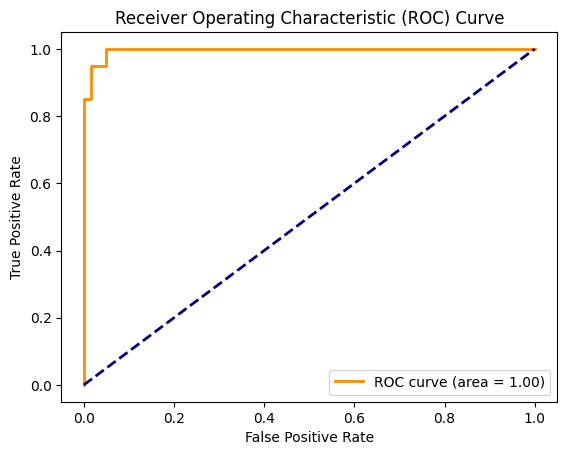

best_threshold = 14.217754364013672


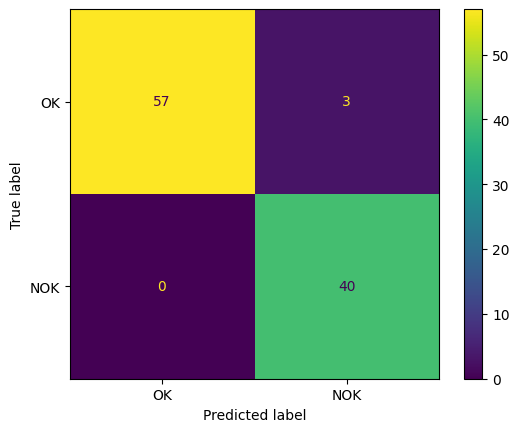

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

## Prediction on Test set

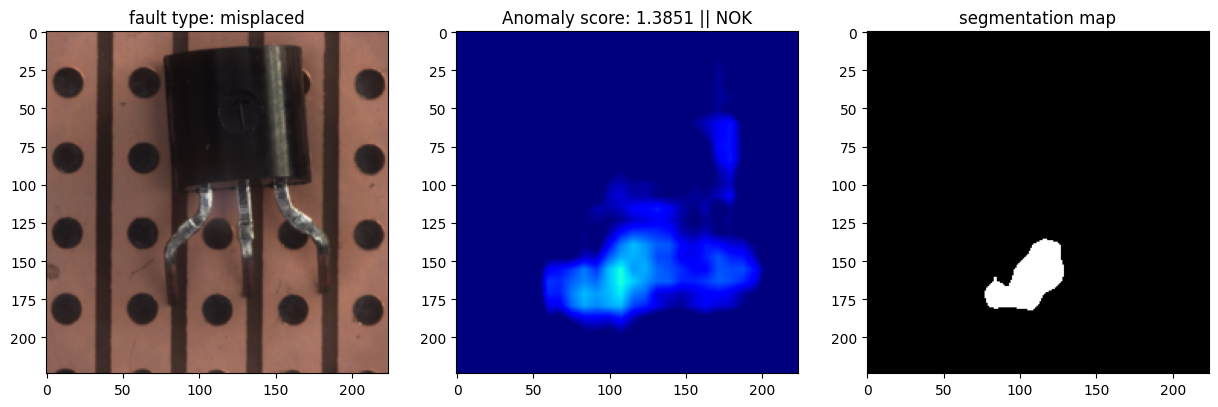

In [19]:
import cv2, time
from IPython.display import clear_output

backbone.eval()

test_path = Path('/content/transistor/test')

for path in test_path.glob('*/*.png'):

    fault_type = path.parts[-2]

    if fault_type in ['misplaced']:

        test_image = transform(Image.open(path)).cuda().unsqueeze(0)

        with torch.no_grad():
            features = backbone(test_image)
        # Forward pass
        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1)
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28)
        # Upscale by bi-linaer interpolation to match the original input resolution
        segm_map = torch.nn.functional.interpolate(
                    segm_map,
                    size=(224, 224),
                    mode='bilinear'
                ).cpu().squeeze().numpy()

        y_score_image = s_star.cpu().numpy()

        y_pred_image = 1*(y_score_image >= best_threshold)
        class_label = ['OK','NOK']


        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map
        plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2)
        plt.title(f'Anomaly score: {y_score_image / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold*1.25), cmap='gray')
        plt.title(f'segmentation map')

        plt.show()

        time.sleep(0.05)
        clear_output(wait=True)